### *Import packages

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("white")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",108)

# 1. Medical Appointments Dataset

In [2]:
med = pd.read_pickle("med.pkl")

In [3]:
med.head()

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Received,No_Show,Day_Of_Week,Waiting_Days
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,Jardim Da Penha,0,1,0,0,0,0,No,Friday,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,Jardim Da Penha,0,0,0,0,0,0,No,Friday,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,Mata Da Praia,0,0,0,0,0,0,No,Friday,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,Pontal De Camburi,0,0,0,0,0,0,No,Friday,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,Jardim Da Penha,0,1,1,0,0,0,No,Friday,0


### 1.1 Drop rows where there's no weather data avalaible
    (I only have historic weather data for Mai 2016)

In [4]:
med.Appointment_Day.unique()

array(['2016-04-29T00:00:00.000000000', '2016-05-03T00:00:00.000000000',
       '2016-05-10T00:00:00.000000000', '2016-05-17T00:00:00.000000000',
       '2016-05-24T00:00:00.000000000', '2016-05-31T00:00:00.000000000',
       '2016-05-02T00:00:00.000000000', '2016-05-30T00:00:00.000000000',
       '2016-05-16T00:00:00.000000000', '2016-05-04T00:00:00.000000000',
       '2016-05-19T00:00:00.000000000', '2016-05-12T00:00:00.000000000',
       '2016-05-06T00:00:00.000000000', '2016-05-20T00:00:00.000000000',
       '2016-05-05T00:00:00.000000000', '2016-05-13T00:00:00.000000000',
       '2016-05-09T00:00:00.000000000', '2016-05-25T00:00:00.000000000',
       '2016-05-11T00:00:00.000000000', '2016-05-18T00:00:00.000000000',
       '2016-05-14T00:00:00.000000000', '2016-06-02T00:00:00.000000000',
       '2016-06-03T00:00:00.000000000', '2016-06-06T00:00:00.000000000',
       '2016-06-07T00:00:00.000000000', '2016-06-01T00:00:00.000000000',
       '2016-06-08T00:00:00.000000000'], dtype='dat

In [5]:
to_drop1 = med[med['Appointment_Day'] < '2016-05-01'].index
to_drop2 = med[med['Appointment_Day'] > '2016-05-30'].index
 
# Delete these row indexes from dataFrame
med.drop(to_drop1, inplace=True)
med.drop(to_drop2, inplace=True)

In [6]:
med['Day'] = med['Appointment_Day'].dt.day

In [7]:
med.Day.unique()

array([ 3, 10, 17, 24,  2, 30, 16,  4, 19, 12,  6, 20,  5, 13,  9, 25, 11,
       18, 14], dtype=int64)

In [8]:
med.shape

(76557, 17)

# 2. Weather Dataset

### 2.1 Create dataset
    based on web scraping of kaggle user:
<a href="https://storage.googleapis.com/kaggle-forum-message-attachments/233710/7720/Bonus.ipynb">Jupyter Notebook File: Ezequiel Bequet</a>


In [9]:
weather_list = [['1', '24.8', '32', '20', '1013.6', '77', '0', '15.8', '7.4', '20.6', '37', '\xa0', '\xa0', 'o', '\xa0'],
['2', '25.2', '30', '21.5', '1012.5', '80', '0.25', '15.3', '9.1', '16.5', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['3', '24.9', '27.1', '23', '1012.7', '78', '0', '13.7', '9.8', '20.6', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['4', '25.2', '29', '22.7', '1012.8', '86', '0', '14.3', '8.3', '25.9', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['5', '25.9', '31', '22', '1013.5', '80', '0', '13.8', '11.7', '25.9', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['6', '26.8', '34', '24', '1011.7', '79', '0', '14.3', '14.6', '31.7', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['7', '24.7', '27', '23', '1011.8', '85', '0', '13', '14.6', '29.4', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['8', '23.4', '25.5', '22', '1016.5', '78', '0', '13.4', '17.6', '25.9', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['9', '20.6', '22', '19', '1019.4', '81', '5.08', '12.1', '15.4', '24.1', '-', 'o', '\xa0', '\xa0', '\xa0'],
['10', '21.4', '24', '19.8', '1020.3', '68', '0', '13.4', '9.6', '16.5', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['11', '21', '23.2', '20', '1019.7', '72', '0.25', '12.2', '15.7', '29.4', '-', 'o', '\xa0', '\xa0', '\xa0'],
['12', '19.9', '21', '18', '1023.7', '66', '0.51', '12.7', '12.6', '16.5', '-', 'o', '\xa0', '\xa0', '\xa0'],
['13', '20', '22.2', '18', '1026.6', '61', '0', '14.6', '21.5', '33.5', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['14', '21.1', '25.1', '17.7', '1027.7', '62', '0', '14.6', '18', '25.9', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['15', '19', '25', '13', '1026.1', '75', '0', '15.3', '9.6', '24.1', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['16', '19.6', '25', '15', '1024', '74', '0', '15.3', '9.8', '22.2', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['17', '20.4', '27', '14.8', '1021.9', '73', '0', '16.7', '9.1', '20.6', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['18', '20.6', '29', '13.5', '1020.4', '71', '0', '18.7', '8.3', '24.1', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['19', '20', '24.5', '15', '1022', '86', '0', '13.5', '8.7', '24.1', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['20', '21.7', '25', '18.7', '1021.3', '87', '0', '11.4', '8', '22.2', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['21', '21.8', '24', '19.7', '1022.9', '83', '6.1', '10.5', '14.3', '27.8', '-', 'o', '\xa0', '\xa0', '\xa0'],
['22', '20.4', '22', '19', '1023.6', '92', '16', '8', '11.7', '20.6', '33.5', 'o', '\xa0', '\xa0', '\xa0'],
['23', '21.9', '28', '17.7', '1020.5', '84', '8.89', '15', '6.1', '16.5', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['24', '22.1', '25', '19', '1021.9', '83', '0', '13.2', '15', '22.2', '-', '\xa0', '\xa0', '\xa0', '\xa0'],
['25', '21.1', '23.2', '19.7', '1025', '85', '0.51', '12.1', '14.1', '22.2', '-', 'o', '\xa0', '\xa0', '\xa0'],
['26', '19.9', '23', '15.8', '1026.2', '88', '6.1', '11.4', '8.7', '20.6', '-', 'o', '\xa0', '\xa0', '\xa0'],
['27', '19.8', '22', '18', '1026.3', '95', '5.08', '8.9', '8.1', '20.6', '-', 'o', '\xa0', '\xa0', '\xa0'],
['28', '21.8', '25', '19.5', '1025.8', '85', '8.89', '10.1', '8', '13', '-', 'o', '\xa0', '\xa0', '\xa0'],
['29', '20.4', '24.2', '17.5', '1024.6', '92', '0', '11.3', '5.2', '16.5', '-', 'o', '\xa0', '\xa0', '\xa0'],
['30', '22.4', '25.5', '20', '1023.9', '90', '2.29', '12.9', '7', '18.3', '-', '\xa0', '\xa0', '\xa0', '\xa0']]

weather = pd.DataFrame(columns=['Day', 'T', 'TM', 'Tm', 'SLP', 'H', 'PP', 'VV', 'V', 'VM', 'VG', 'RA', 'SN', 'TS', 'FG'], data=weather_list)

### 2.2 Analysis & cleaning

In [10]:
weather.head()

,Day,T,TM,Tm,SLP,H,PP,VV,V,VM,VG,RA,SN,TS,FG
0,1,24.8,32,20,1013.6,77,0,15.8,7.4,20.6,37,,,o,
1,2,25.2,30,21.5,1012.5,80,0.25,15.3,9.1,16.5,-,,,,
2,3,24.9,27.1,23,1012.7,78,0,13.7,9.8,20.6,-,,,,
3,4,25.2,29,22.7,1012.8,86,0,14.3,8.3,25.9,-,,,,
4,5,25.9,31,22,1013.5,80,0,13.8,11.7,25.9,-,,,,


column descriptions:<br>
<br>
Day - day date of Mai, 2016<br>
T - average temperature (ºC.)<br>
TM - maximum average temperature (ºC.)<br>
Tm - minimum average temperature (ºC.)<br>
SLP - atmospheric pressure at sea level<br>
H - average relative humidity<br>
PP - total rainfall and / or melted snow<br>
VV - average visibility (Km)<br>
V - average wind speed (Km/h)<br>
VM - maximum sustained wind speed (Km/h)<br>

In [11]:
weather.dtypes

Day    object
T      object
TM     object
Tm     object
SLP    object
H      object
PP     object
VV     object
V      object
VM     object
VG     object
RA     object
SN     object
TS     object
FG     object
dtype: object

In [12]:
weather.drop(['VG', 'RA', 'SN', 'TS', 'FG'], axis=1, inplace=True)

In [13]:
weather.isnull().sum(axis = 0)

Day    0
T      0
TM     0
Tm     0
SLP    0
H      0
PP     0
VV     0
V      0
VM     0
dtype: int64

In [14]:
weather[['T', 'TM', 'Tm', 'SLP', 'H', 'PP', 'VV', 'V', 'VM']] = weather[['T', 'TM', 'Tm', 'SLP', 'H', 'PP', 'VV', 'V', 'VM']].apply(pd.to_numeric)

In [15]:
weather[['Day']] = weather[['Day']].astype('int')

In [16]:
weather.dtypes

Day      int32
T      float64
TM     float64
Tm     float64
SLP    float64
H        int64
PP     float64
VV     float64
V      float64
VM     float64
dtype: object

### 2.3 Plotting

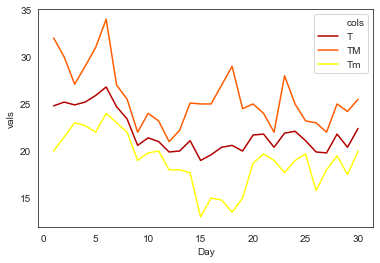

In [17]:
#sns.lineplot(x='Day', y=[['T','TM','Tm']], data=weather, palette="hot", linewidth=2.5);

temp = weather[['Day','T','TM','Tm']].melt('Day', var_name='cols',  value_name='vals')
temp_plot = sns.lineplot(x="Day", y="vals", hue='cols', data=temp, palette="hot")

In [18]:
weather.nlargest(5, ['T'])[['Day','T']]

,Day,T
5,6,26.8
4,5,25.9
1,2,25.2
3,4,25.2
2,3,24.9


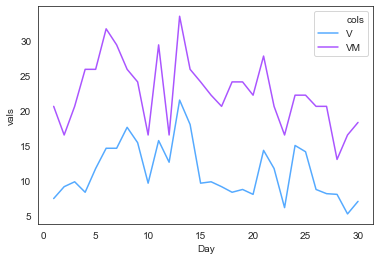

In [19]:
wind = weather[['Day','V','VM']].melt('Day', var_name='cols',  value_name='vals')
wind_speed_plot = sns.lineplot(x="Day", y="vals", hue='cols', data=wind, palette="cool")

In [20]:
weather.nlargest(5, ['V'])[['Day','V']]

,Day,V
12,13,21.5
13,14,18.0
7,8,17.6
10,11,15.7
8,9,15.4


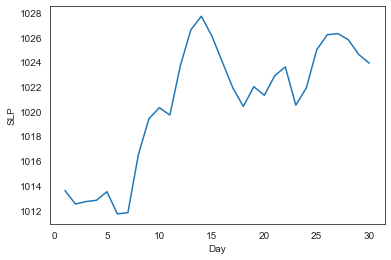

In [21]:
pressure_plot = sns.lineplot(x="Day", y="SLP", data=weather)

In [22]:
weather.nlargest(5, ['SLP'])[['Day','SLP']]

,Day,SLP
13,14,1027.7
12,13,1026.6
26,27,1026.3
25,26,1026.2
14,15,1026.1


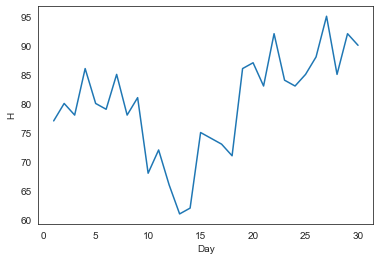

In [23]:
humidity_plot = sns.lineplot(x="Day", y="H", data=weather)

In [24]:
weather.nlargest(5, ['H'])[['Day','H']]

,Day,H
26,27,95
21,22,92
28,29,92
29,30,90
25,26,88


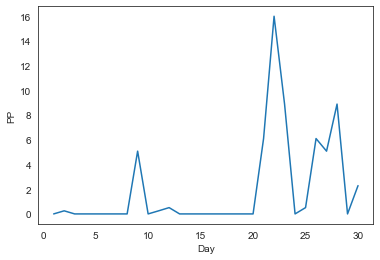

In [25]:
rain_snow_plot = sns.lineplot(x="Day", y="PP", data=weather)

In [26]:
weather.PP.value_counts()

0.00     18
8.89      2
6.10      2
0.51      2
5.08      2
0.25      2
2.29      1
16.00     1
Name: PP, dtype: int64

In [27]:
weather.nlargest(5, ['PP'])[['Day','PP']]

,Day,PP
21,22,16.00
22,23,8.89
27,28,8.89
20,21,6.10
25,26,6.10


In 12 out of 30 days, it was rainy/snowy. 

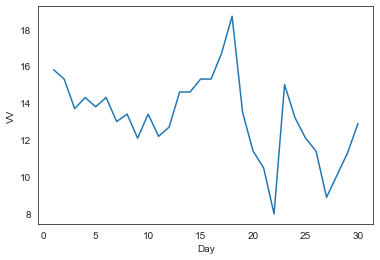

In [28]:
visibility_plot = sns.lineplot(x="Day", y="VV", data=weather)

In [29]:
# replace largest to find lowest 5 data points
weather.nlargest(30, ['VV'])[['Day','VV']]

,Day,VV
17,18,18.7
16,17,16.7
0,1,15.8
14,15,15.3
1,2,15.3
15,16,15.3
22,23,15.0
12,13,14.6
13,14,14.6
5,6,14.3


# 3. Merge two datasets

### 3.1 Merge medical appointments dataset and weather dataset on 'Day'

In [30]:
med_weather = pd.merge(med, weather, how='left', on='Day')

In [31]:
med_weather.drop(['Day'], axis=1, inplace=True)

In [32]:
med_weather.head()

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Received,No_Show,Day_Of_Week,Waiting_Days,T,TM,Tm,SLP,H,PP,VV,V,VM
0,49839442791312,5530556,F,2016-03-31,2016-05-03,49,Maria Ortiz,0,0,0,0,0,1,Yes,Tuesday,33,24.9,27.1,23.0,1012.7,78,0.0,13.7,9.8,20.6
1,89577527157879,5549661,F,2016-04-06,2016-05-10,73,Maria Ortiz,0,0,0,0,0,1,No,Tuesday,34,21.4,24.0,19.8,1020.3,68,0.0,13.4,9.6,16.5
2,466144648716,5613929,F,2016-04-25,2016-05-17,51,Maria Ortiz,0,0,0,0,0,0,No,Tuesday,22,20.4,27.0,14.8,1021.9,73,0.0,16.7,9.1,20.6
3,86781189971276,5731976,F,2016-05-24,2016-05-24,20,Maria Ortiz,0,0,0,0,0,0,No,Tuesday,0,22.1,25.0,19.0,1021.9,83,0.0,13.2,15.0,22.2
4,22485762244839,5530614,F,2016-03-31,2016-05-03,24,Maria Ortiz,0,0,0,0,0,1,Yes,Tuesday,33,24.9,27.1,23.0,1012.7,78,0.0,13.7,9.8,20.6


In [33]:
med_weather.dtypes

Patient_ID                  int64
Appointment_ID              int64
Gender                     object
Scheduled_Day      datetime64[ns]
Appointment_Day    datetime64[ns]
Age                         int64
Neighbourhood              object
Scholarship                 int64
Hypertension                int64
Diabetes                    int64
Alcoholism                  int64
Handicap                    int64
SMS_Received                int64
No_Show                    object
Day_Of_Week                object
Waiting_Days                int64
T                         float64
TM                        float64
Tm                        float64
SLP                       float64
H                           int64
PP                        float64
VV                        float64
V                         float64
VM                        float64
dtype: object

# 4. Prepare 'med_weather' for Machine Learning

### 4.1 Casting variable types, applying min-max-scaler

In [34]:
med_weather['Gender'] = (med_weather['Gender'] == 'F').astype(int) #keeping Female (F) in Gender as 1, else 0
med_weather['No_Show'] = (med_weather['No_Show'] == 'Yes').astype(int) #keeping Yes in No_Show as 1, else 0

In [35]:
# Create Age_floats to store age values as floats
Age_floats = med_weather[['Age']].values.astype(float)

# Create min & max processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
Age_scaled = min_max_scaler.fit_transform(Age_floats)

In [36]:
med_weather['Age_Normalized'] = Age_scaled

In [37]:
med_weather.drop(['Age'], axis=1, inplace=True)

In [38]:
Waiting_days_floats = med_weather[['Waiting_Days']].values.astype(float)

# Create an object to transform the data to fit minmax processor
Waiting_days_scaled = min_max_scaler.fit_transform(Waiting_days_floats)

In [39]:
med_weather['Waiting_Days_Normalized'] = Waiting_days_floats

In [40]:
med_weather.drop(['Waiting_Days'], axis=1, inplace=True)

In [41]:
# Create an object to transform the data to fit minmax processor
T_scaled = min_max_scaler.fit_transform(med_weather[['T']])
TM_scaled = min_max_scaler.fit_transform(med_weather[['TM']])
Tm_scaled = min_max_scaler.fit_transform(med_weather[['Tm']])
SLP_scaled = min_max_scaler.fit_transform(med_weather[['SLP']])
H_scaled = min_max_scaler.fit_transform(med_weather[['H']])
PP_scaled = min_max_scaler.fit_transform(med_weather[['PP']])
VV_scaled = min_max_scaler.fit_transform(med_weather[['VV']])
V_scaled = min_max_scaler.fit_transform(med_weather[['V']])
VM_scaled = min_max_scaler.fit_transform(med_weather[['VM']])

In [42]:
med_weather['T_Normalized'] = T_scaled
med_weather['TM_Normalized'] = TM_scaled
med_weather['Tm_Normalized'] = Tm_scaled
med_weather['SLP_Normalized'] = SLP_scaled
med_weather['H_Normalized'] = H_scaled
med_weather['PP_Normalized'] = PP_scaled
med_weather['VV_Normalized'] = VV_scaled
med_weather['V_Normalized'] = V_scaled
med_weather['VM_Normalized'] = VM_scaled

In [43]:
med_weather.drop(['T'], axis=1, inplace=True)
med_weather.drop(['TM'], axis=1, inplace=True)
med_weather.drop(['Tm'], axis=1, inplace=True)
med_weather.drop(['SLP'], axis=1, inplace=True)
med_weather.drop(['H'], axis=1, inplace=True)
med_weather.drop(['PP'], axis=1, inplace=True)
med_weather.drop(['VV'], axis=1, inplace=True)
med_weather.drop(['V'], axis=1, inplace=True)
med_weather.drop(['VM'], axis=1, inplace=True)

In [45]:
med_weather.head()

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_Received,No_Show,Day_Of_Week,Age_Normalized,Waiting_Days_Normalized,T_Normalized,TM_Normalized,Tm_Normalized,SLP_Normalized,H_Normalized,PP_Normalized,VV_Normalized,V_Normalized,VM_Normalized
0,49839442791312,5530556,1,2016-03-31,2016-05-03,Maria Ortiz,0,0,0,0,0,1,1,Tuesday,0.426087,33.0,0.736111,0.469231,0.904762,0.0625,0.586207,0.0,0.315068,0.193103,0.241176
1,89577527157879,5549661,1,2016-04-06,2016-05-10,Maria Ortiz,0,0,0,0,0,1,0,Tuesday,0.634783,34.0,0.250000,0.230769,0.600000,0.5375,0.241379,0.0,0.273973,0.179310,0.000000
2,466144648716,5613929,1,2016-04-25,2016-05-17,Maria Ortiz,0,0,0,0,0,0,0,Tuesday,0.443478,22.0,0.111111,0.461538,0.123810,0.6375,0.413793,0.0,0.726027,0.144828,0.241176
3,86781189971276,5731976,1,2016-05-24,2016-05-24,Maria Ortiz,0,0,0,0,0,0,0,Tuesday,0.173913,0.0,0.347222,0.307692,0.523810,0.6375,0.758621,0.0,0.246575,0.551724,0.335294
4,22485762244839,5530614,1,2016-03-31,2016-05-03,Maria Ortiz,0,0,0,0,0,1,1,Tuesday,0.208696,33.0,0.736111,0.469231,0.904762,0.0625,0.586207,0.0,0.315068,0.193103,0.241176


### 4.2 Get dummies

In [46]:
med_weather_ml = pd.get_dummies(med_weather,  columns=["Neighbourhood", "Handicap", "SMS_Received", "Day_Of_Week"], drop_first=True)
med_weather_ml.head()

,Patient_ID,Appointment_ID,Gender,Scheduled_Day,Appointment_Day,Scholarship,Hypertension,Diabetes,Alcoholism,No_Show,Age_Normalized,Waiting_Days_Normalized,T_Normalized,TM_Normalized,Tm_Normalized,SLP_Normalized,H_Normalized,PP_Normalized,VV_Normalized,V_Normalized,VM_Normalized,Neighbourhood_Andorinhas,Neighbourhood_Antônio Honório,Neighbourhood_Ariovaldo Favalessa,Neighbourhood_Barro Vermelho,Neighbourhood_Bela Vista,Neighbourhood_Bento Ferreira,Neighbourhood_Boa Vista,Neighbourhood_Bonfim,Neighbourhood_Caratoíra,Neighbourhood_Centro,Neighbourhood_Comdusa,Neighbourhood_Conquista,Neighbourhood_Consolação,Neighbourhood_Cruzamento,Neighbourhood_Da Penha,Neighbourhood_De Lourdes,Neighbourhood_Do Cabral,Neighbourhood_Do Moscoso,Neighbourhood_Do Quadro,Neighbourhood_Enseada Do Suá,Neighbourhood_Estrelinha,Neighbourhood_Fonte Grande,Neighbourhood_Forte São João,Neighbourhood_Fradinhos,Neighbourhood_Goiabeiras,Neighbourhood_Grande Vitória,Neighbourhood_Gurigica,Neighbourhood_Horto,Neighbourhood_Ilha Das Caieiras,...,Neighbourhood_Jesus De Nazareth,Neighbourhood_Joana D´Arc,Neighbourhood_Jucutuquara,Neighbourhood_Maria Ortiz,Neighbourhood_Maruípe,Neighbourhood_Mata Da Praia,Neighbourhood_Monte Belo,Neighbourhood_Morada De Camburi,Neighbourhood_Mário Cypreste,Neighbourhood_Nazareth,Neighbourhood_Nova Palestina,Neighbourhood_Parque Industrial,Neighbourhood_Parque Moscoso,Neighbourhood_Piedade,Neighbourhood_Pontal De Camburi,Neighbourhood_Praia Do Canto,Neighbourhood_Praia Do Suá,Neighbourhood_Redenção,Neighbourhood_República,Neighbourhood_Resistência,Neighbourhood_Romão,Neighbourhood_Santa Cecília,Neighbourhood_Santa Clara,Neighbourhood_Santa Helena,Neighbourhood_Santa Luíza,Neighbourhood_Santa Lúcia,Neighbourhood_Santa Martha,Neighbourhood_Santa Tereza,Neighbourhood_Santo André,Neighbourhood_Santo Antônio,Neighbourhood_Santos Dumont,Neighbourhood_Santos Reis,Neighbourhood_Segurança Do Lar,Neighbourhood_Solon Borges,Neighbourhood_São Benedito,Neighbourhood_São Cristóvão,Neighbourhood_São José,Neighbourhood_São Pedro,Neighbourhood_Tabuazeiro,Neighbourhood_Universitário,Neighbourhood_Vila Rubim,Handicap_1,Handicap_2,Handicap_3,SMS_Received_1,Day_Of_Week_Monday,Day_Of_Week_Saturday,Day_Of_Week_Thursday,Day_Of_Week_Tuesday,Day_Of_Week_Wednesday
0,49839442791312,5530556,1,2016-03-31,2016-05-03,0,0,0,0,1,0.426087,33.0,0.736111,0.469231,0.904762,0.0625,0.586207,0.0,0.315068,0.193103,0.241176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,89577527157879,5549661,1,2016-04-06,2016-05-10,0,0,0,0,0,0.634783,34.0,0.250000,0.230769,0.600000,0.5375,0.241379,0.0,0.273973,0.179310,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,466144648716,5613929,1,2016-04-25,2016-05-17,0,0,0,0,0,0.443478,22.0,0.111111,0.461538,0.123810,0.6375,0.413793,0.0,0.726027,0.144828,0.241176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,86781189971276,5731976,1,2016-05-24,2016-05-24,0,0,0,0,0,0.173913,0.0,0.347222,0.307692,0.523810,0.6375,0.758621,0.0,0.246575,0.551724,0.335294,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,22485762244839,5530614,1,2016-03-31,2016-05-03,0,0,0,0,1,0.208696,33.0,0.736111,0.469231,0.904762,0.0625,0.586207,0.0,0.315068,0.193103,0.241176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


### 4.3 Create correlation table

In [47]:
med_weather_ml1 = med_weather_ml.copy()

In [48]:
med_weather_ml1 = med_weather_ml1.drop(columns='No_Show')

In [49]:
corr = med_weather_ml1.corrwith(med_weather_ml['No_Show'])

In [50]:
correlation = corr.sort_values(ascending=False).to_frame()

In [51]:
correlation

,0
Waiting_Days_Normalized,0.194811
SMS_Received_1,0.118150
Neighbourhood_Itararé,0.036940
Scholarship,0.030992
Neighbourhood_Santos Dumont,0.022123
Neighbourhood_Jesus De Nazareth,0.015572
Neighbourhood_Caratoíra,0.013184
Neighbourhood_Santa Cecília,0.011700
Neighbourhood_Ilha Do Príncipe,0.010236
Neighbourhood_Ilhas Oceânicas De Trindade,0.009931


### 4.4 Split dataset into train and test

In [52]:
y = med_weather_ml[['No_Show']]#target / response as dependent variable

X = med_weather_ml.drop(['Patient_ID',
                 'Appointment_ID',
                 'Scheduled_Day', 
                 'Appointment_Day',
                 'No_Show'], axis=1) #predictors as independent variables

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=666)

In [54]:
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (61245, 105)
Number transactions y_train dataset:  (61245, 1)
Number transactions X_test dataset:  (15312, 105)
Number transactions y_test dataset:  (15312, 1)


In [67]:
y_train = pd.DataFrame.to_numpy(y_train)

### 4.5 Balance dataset
    The target variable in the dataset is clearly imbalanced, as there are only 16032 occurences (20,9%)
    where patients did not show up to their appointments and 60525 occurences (79,1%) where they did.
    Hence, the dataset needs to be balanced.
   
I use **SMOTE (Synthetic Minority Over-sampling Technique)** to balance the data:


In [68]:
med_weather_ml.No_Show.value_counts()

0    60525
1    16032
Name: No_Show, dtype: int64

In [70]:
sm = SMOTE() 
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train.ravel()) 

In [73]:
# describes info about train and test set 
print("Number transactions X_train dataset: ", X_train_resampled.shape) 
print("Number transactions y_train dataset: ", y_train_resampled.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 

Number transactions X_train dataset:  (96814, 105)
Number transactions y_train dataset:  (96814,)
Number transactions X_test dataset:  (15312, 105)
Number transactions y_test dataset:  (15312, 1)


In [108]:
y_test.head()

,No_Show
19833,0
39836,0
25577,0
46190,0
67815,0


# 5. Modelling

### 5.1 Random Forest Model

In [76]:
rf_model = RandomForestClassifier(random_state=666, n_estimators=100).fit(X_train_resampled, y_train_resampled.ravel())

In [77]:
print("Model Feature Importances:\n")

for name, importance in zip(X.columns, np.sort(rf_model.feature_importances_)[::-1]):
    print(name,": {:.2f}".format(importance))

Model Feature Importances:

Gender : 0.26
Scholarship : 0.24
Hypertension : 0.03
Diabetes : 0.02
Alcoholism : 0.01
Age_Normalized : 0.01
Waiting_Days_Normalized : 0.01
T_Normalized : 0.01
TM_Normalized : 0.01
Tm_Normalized : 0.01
SLP_Normalized : 0.01
H_Normalized : 0.01
PP_Normalized : 0.01
VV_Normalized : 0.01
V_Normalized : 0.01
VM_Normalized : 0.01
Neighbourhood_Andorinhas : 0.01
Neighbourhood_Antônio Honório : 0.01
Neighbourhood_Ariovaldo Favalessa : 0.01
Neighbourhood_Barro Vermelho : 0.01
Neighbourhood_Bela Vista : 0.01
Neighbourhood_Bento Ferreira : 0.01
Neighbourhood_Boa Vista : 0.01
Neighbourhood_Bonfim : 0.01
Neighbourhood_Caratoíra : 0.01
Neighbourhood_Centro : 0.01
Neighbourhood_Comdusa : 0.01
Neighbourhood_Conquista : 0.01
Neighbourhood_Consolação : 0.01
Neighbourhood_Cruzamento : 0.01
Neighbourhood_Da Penha : 0.01
Neighbourhood_De Lourdes : 0.01
Neighbourhood_Do Cabral : 0.01
Neighbourhood_Do Moscoso : 0.01
Neighbourhood_Do Quadro : 0.01
Neighbourhood_Enseada Do Suá : 0.

In [78]:
print("Random Forest Accuracy Score: \n", rf_model.score(X_test, y_test))

Random Forest Accuracy Score: 
 0.7159743991640544


In [79]:
print("Random Forest Confusion Matrix: \n", confusion_matrix(y_test,rf_model.predict(X_test)))

Random Forest Confusion Matrix: 
 [[9580 2538]
 [1811 1383]]


In [116]:
print("Random Forest Probability Estimates for 'No_Show': \n", rf_model.predict_proba(X_test))

Random Forest Probability Estimates for 'No_Show': 
 [[0.77       0.23      ]
 [0.82       0.18      ]
 [0.97       0.03      ]
 ...
 [0.68333333 0.31666667]
 [0.446      0.554     ]
 [0.94       0.06      ]]


### 5.2 Bernoulli Naive Bayes Model

In [82]:
bnb_model =  BernoulliNB().fit(X_train_resampled, y_train_resampled.ravel())

In [83]:
print("Bernoulli Naive Bayes Accuracy Score: ", bnb_model.score(X_test, y_test))

Bernoulli Naive Bayes Accuracy Score:  0.6079545454545454


In [84]:
print("Bernoulli Naive Bayes Confusion Matrix: \n", confusion_matrix(y_test,bnb_model.predict(X_test)))

Bernoulli Naive Bayes Confusion Matrix: 
 [[7068 5050]
 [ 953 2241]]


In [115]:
print("Bernoulli Naive Bayes Probability Estimates for 'No_Show': \n", bnb_model.predict_proba(X_test))

Bernoulli Naive Bayes Probability Estimates for 'No_Show': 
 [[0.84766907 0.15233093]
 [0.8497981  0.1502019 ]
 [0.94650845 0.05349155]
 ...
 [0.87464232 0.12535768]
 [0.63108924 0.36891076]
 [0.46135276 0.53864724]]


### 5.3 Support Vector Machines Model

In [89]:
svm_model = svm.SVC(gamma='auto').fit(X_train_resampled, y_train_resampled.ravel())

In [90]:
print("Support Vector Machines Accuracy Score: ",svm_model.score(X_test, y_test))

Support Vector Machines Accuracy Score:  0.6400862068965517


In [91]:
print("Support Vector Machines Confusion Matrix: \n", confusion_matrix(y_test,svm_model.predict(X_test)))

Support Vector Machines Confusion Matrix: 
 [[7659 4459]
 [1052 2142]]


In [112]:
print("Support Vector Machines Estimates for 'No_Show': \n", svm_model.predict(X_test))

array([0, 0, 0, ..., 0, 1, 0])

### 5.4 Logistic Regression Model

In [86]:
lg_model = LogisticRegression(random_state=666, solver='lbfgs', max_iter=2000).fit(X_train_resampled, y_train_resampled.ravel())

In [87]:
print("Logistic Regression Accuracy Score: ",lg_model.score(X_test, y_test))

Logistic Regression Accuracy Score:  0.7392241379310345


In [88]:
print("Logistic Regression Confusion Matrix: \n", confusion_matrix(y_test,lg_model.predict(X_test)))

Logistic Regression Confusion Matrix: 
 [[10425  1693]
 [ 2300   894]]


In [114]:
print("Logistic Regression Probability Estimates for 'No_Show': \n", lg_model.predict_proba(X_test))

Logistic Regression Probability Estimates for 'No_Show': 
 [[0.62666693 0.37333307]
 [0.70428147 0.29571853]
 [0.64134907 0.35865093]
 ...
 [0.80738235 0.19261765]
 [0.4983417  0.5016583 ]
 [0.66759743 0.33240257]]
